# Color quantization & first evaluation of color histogram classifier

## Loading the data

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from ipywidgets import interact
import ipywidgets as widgets

In [2]:
"""
The file hierarchy is as follow:
data/
├── labels.txt
├── README.md
└── train
    ├── 01
    │   ├── c01_s00.png
    │   ├── c04_s01.png
    │   ├── c07_s03.png
    │   ├── c30_s03.png
    │   └── c34_s03.png
    ├── 02
    │   ├── c01_s01.png
    │   ├── c09_s00.png
    │   ├── c14_s05.png
    │   ├── c32_s00.png
    │   └── c53_s03.png
    ...
    └── 57
        ├── c24_s00.png
        ├── c25_s01.png
        ├── c31_s03.png
        ├── c33_s07.png
        └── c51_s04.png

Note:
    Be careful class id are 1-indexed
"""

PATH_TO_RESOURCES = "./data/train" # Adapt to your data folder

In [3]:
def _get_image(directory: str, filename: str) -> np.array:
    """
    Returns the image (as an np.array) from the file located in a
    `directory` and with a `filename`.
    
    Note:
        The images have variable size.
    """
    img = cv2.imread(os.path.join(PATH_TO_RESOURCES, directory, filename))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def _get_class(directory: str, filename: str) -> np.array:
    """
    Returns the class associated with a `directory`.
    
    Note:
        'filename` is not used here, but still in argument
        for interface convenience
    """
    return int(directory)

def _apply_on_flatten_dir(path: str, *, func=_get_class, type_=object) -> np.array:
    """
    Returns the flatten list of files in each sub-directory at `path`
    and apply `func` to each file.
    """
    return np.array([
        func(directory, filename)
        for directory in os.listdir(PATH_TO_RESOURCES)
        for filename in os.listdir(os.path.join(PATH_TO_RESOURCES, directory))
    ], dtype=type_)

def get_data(path: str = PATH_TO_RESOURCES) -> (np.array, np.array):
    """
    Returns X (features) and Y (labels) as a tupple of np.array.
    The `path` specify where the data is stored.
    """
    return (_apply_on_flatten_dir(path, func=_get_image),
            _apply_on_flatten_dir(path, func=_get_class, type_=int))

In [4]:
X, Y = get_data()
X.shape, Y.shape

((285,), (285,))

## What the data look like ?

In [5]:
nb_class = np.max(Y)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    for i, x in enumerate(X[Y == class_]):
        ax_arr[i].imshow(x)

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

# Color reduction

## Image mask

In [6]:
gray_threshold = 245

masks = np.array([
    img.sum(axis=-1) < (gray_threshold * 3)
    for img in X
], dtype=object)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    for i, mask in enumerate(masks[Y == class_]):
        ax_arr[i].imshow(mask, cmap='gray')

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

## Sampling pixels

In [7]:
nb_sample = 50000

nb_images = nb_class * 5
nb_sample_per_image = nb_sample // nb_images

sample_pxls = X[0][masks[0]][0] # Initialize arbitrary to be able to use np.vstack
for img, mask in zip(X[1:], masks[1:]):
    pxls = img[mask]
    new_sample_pxls_id = np.random.choice(pxls.shape[0], size=nb_sample_per_image, replace=False)
    sample_pxls = np.vstack((sample_pxls, pxls[new_sample_pxls_id]))

sample_pxls.shape, sample_pxls.dtype

((49701, 3), dtype('uint8'))

## Selecting color quantization threshold

In [8]:
from sklearn.cluster import KMeans

2


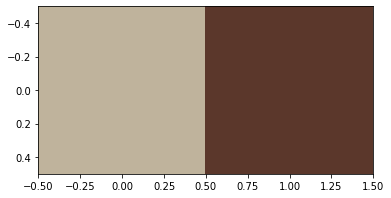

3


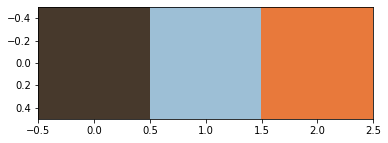

4


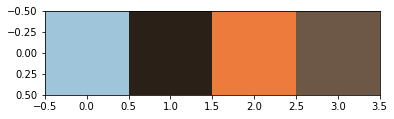

5


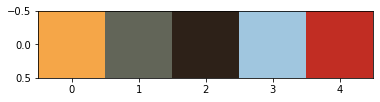

6


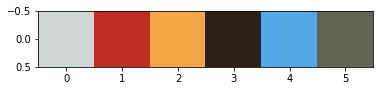

7


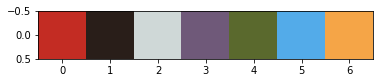

8


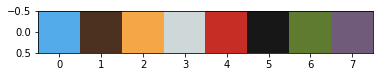

9


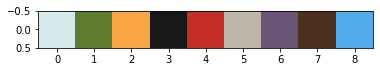

10


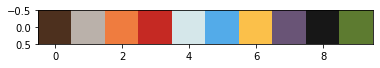

11


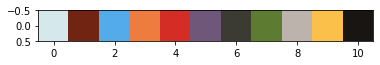

12


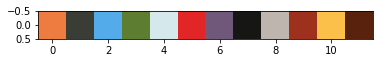

13


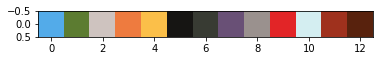

14


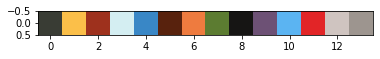

15


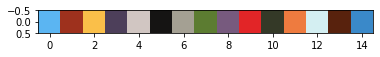

16


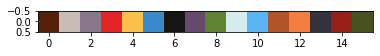

17


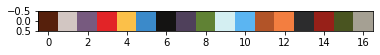

18


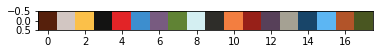

19


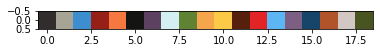

In [9]:
# How to choose the right number of colors ?

inertias = []
for i in range(2, 20):
    print(i)
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(sample_pxls)
    inertias.append(kmeans.inertia_)
    
    new_color = kmeans.cluster_centers_.astype(np.uint8)
    plt.imshow(new_color[np.newaxis, :, :])
    plt.show()

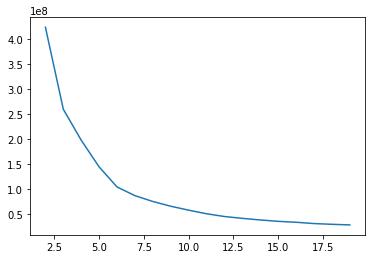

In [10]:
plt.plot(range(2, 20), inertias)

[[195  44  35]
 [ 41  30  25]
 [207 216 215]
 [111  89 121]
 [ 90 105  45]
 [ 83 171 233]
 [245 165  71]]


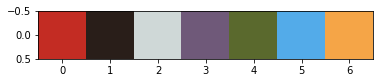

In [11]:
# Example of color sampling
nb_color = 7

kmeans = KMeans(n_clusters=nb_color, random_state=42)
kmeans.fit(sample_pxls)
new_color_lut = kmeans.cluster_centers_.astype(np.uint8)

print(new_color_lut)
plt.imshow(new_color_lut[np.newaxis, :, :]);

In [12]:
color_maps = np.array([
    kmeans.predict(img[mask])
    for img, mask in zip(X, masks)
], dtype=object)
color_maps[0]

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

In [13]:
def get_recolored_img(img: np.array, mask: np.array, color_map: np.array) -> np.array:
    recolored_img = np.full_like(img, 255)
    recolored_img[mask] = new_color_lut[color_map]
    
    return recolored_img

recolored_X = np.array([
    get_recolored_img(img, mask, color_map)
    for img, mask, color_map in zip(X, masks, color_maps)
], dtype=object)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=2, ncols=5, figsize=(12,4))
    for i, (recolored_x, x) in enumerate(zip(recolored_X[Y == class_], X[Y == class_])):
        ax_arr[0, i].imshow(recolored_x)
        ax_arr[1, i].imshow(x)

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

## Compute the color histograms

In [14]:
def get_hist(color_map: np.array) -> np.array:
    hist = np.bincount(color_map, minlength=nb_color)
    norm_hist = hist / color_map.shape[0]
    
    return norm_hist

color_histograms = np.array([get_hist(color_map) for color_map in color_maps], dtype=object)
color_histograms[0]

array([0.22073342736248236, 0.2782087447108604, 0.04610366713681241,
       0.025035260930888575, 0.08286318758815232, 0.0,
       0.34705571227080395], dtype=object)

In [15]:
colors_for_bars = new_color_lut / 255  # matplotlib colors are RGB values scaled to [0,1]

@interact(x_index=widgets.BoundedIntText(max=X.shape[0]))
def show_histograms(x_index: int) -> None:
    plt.figure(figsize=(8,4))
    plt.subplot(1,3,1)
    plt.imshow(X[x_index])
    plt.axis('off'); plt.title("Original")
    plt.subplot(1,3,2)
    plt.imshow(recolored_X[x_index])
    plt.axis('off'); plt.title("Recolored")
    plt.subplot(1,3,3, aspect=len(color_histograms[0]))
    plt.ylim(0, 1)
    plt.bar(range(len(color_histograms[x_index])), 
            color_histograms[x_index] / color_histograms[x_index].max(), 
            color=colors_for_bars)
    plt.xticks([]); plt.title("Histogram")
    plt.show()

interactive(children=(BoundedIntText(value=0, description='x_index', max=285), Output()), _dom_classes=('widge…

## Compute the distance matrix
Because color histograms are **very compact**, it is **very fast** to compute the distance matrix (even if the complexity is $O(n^2)$).

In [16]:
from scipy.spatial.distance import cosine

dist_mat = np.ones((len(X), len(X))) # distances will be between 0 (closest) and 1 (farthest)
for i in range(len(X)):
    for j in range(len(X)):
        dist_mat[i,j] = cosine(color_histograms[i], color_histograms[j])

Correct the diagonal to avoid getting the same result over and over: we set the distance of one element against itself to the maximum distance.

In [17]:
dist_mat[np.diag_indices_from(dist_mat)] = 1

In [18]:
idx_of_best_matches_per_row = np.argsort(dist_mat, axis=1)

## Find the best matches for each image

In [19]:
nb_images_displayed = 5

@interact(x_index=widgets.BoundedIntText(max=X.shape[0] - 1))
def show_similar_images(x_index: int) -> None:
    plt.figure(figsize=(12,8))
    nb_columns = nb_images_displayed + 1
    
    plt.subplot(1, nb_columns, 1)
    plt.imshow(recolored_X[x_index])
    plt.axis("off")
    plt.title("Original")
    
    for image_id in range(nb_images_displayed):
        idx = idx_of_best_matches_per_row[x_index, image_id]
        plt.subplot(1, nb_columns, image_id + 2)
        plt.imshow(recolored_X[idx])
        plt.axis("off")
        plt.title(f"({dist_mat[x_index, idx]: .6f})")

interactive(children=(BoundedIntText(value=0, description='x_index', max=284), Output()), _dom_classes=('widge…

A priori le nb de trous n'est pas ideal en second discriminateur. Contre-example:
- 0
- Peut-etre le 10 (jsp si 2 ou 3 trous)

Idees d'amelioration:
- Tester d'autres distances
- Reduire la "Color quantization" (a.k.a augmenter le nbr de couleurs) pour avoir une distance d'histogramme plus perinente
- Discrimineur de formes
- Tester
    - Soit d'augmenter le nombre de couleurs pour avoir un histogram + precis
    - Soit de tester des discriminateurs de formes

# Classifier base on image color histogram

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier()
cross_val_score(knn, color_histograms, Y, cv=5)

array([0.85964912, 0.87719298, 0.85964912, 0.9122807 , 0.89473684])

In [21]:
from sklearn.svm import SVC

svc = SVC()
cross_val_score(svc, color_histograms, Y, cv=5)

array([0.87719298, 0.89473684, 0.87719298, 0.89473684, 0.89473684])

In [22]:
from sklearn.model_selection import cross_validate

dict_ = cross_validate(knn, color_histograms, Y, cv=5, return_estimator=True)
dict_["test_score"]

array([0.85964912, 0.87719298, 0.85964912, 0.9122807 , 0.89473684])

In [23]:
best_knn = dict_["estimator"][1]

In [24]:
dict_svc = cross_validate(svc, color_histograms, Y, cv=5, return_estimator=True)
dict_svc["test_score"]

array([0.87719298, 0.89473684, 0.87719298, 0.89473684, 0.89473684])

In [25]:
best_svc = dict_svc["estimator"][1]

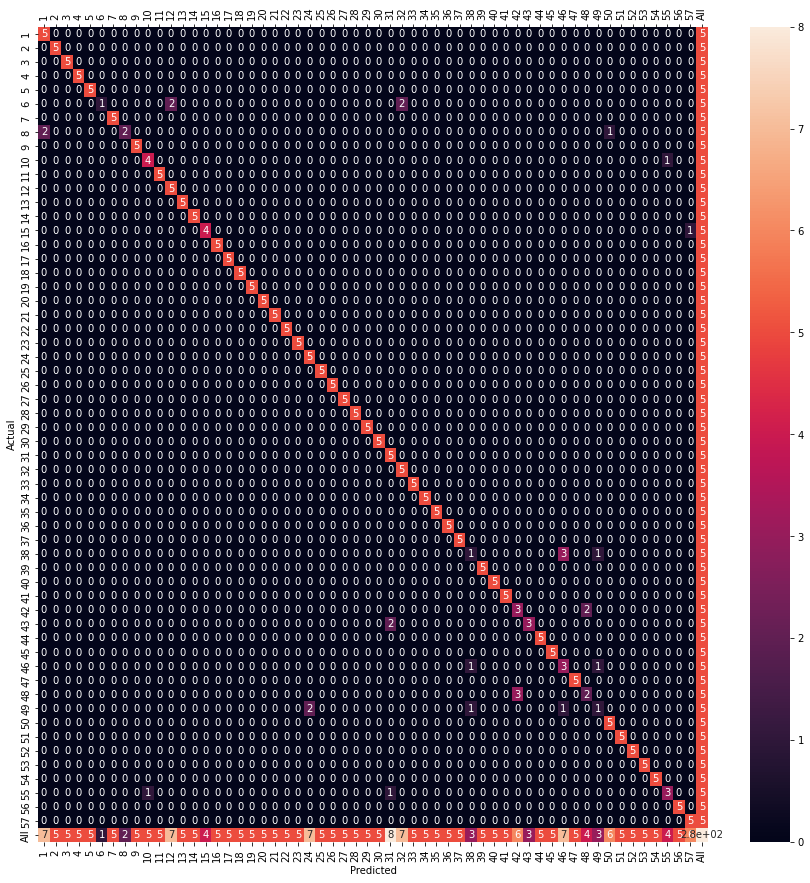

In [26]:
import pandas as pd
import seaborn as sn

def print_confusion_matrix(predicted: np.array, actual: np.array) -> None:
    confusion_matrix = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'], margins=True)
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=True, bottom=True, top=True, labeltop=True)
    sn.heatmap(confusion_matrix, annot=True, vmax=np.max(confusion_matrix.max()[:-1]))
    plt.show()
    
plt.rcParams["figure.figsize"] = (15,15)
print_confusion_matrix(best_svc.predict(color_histograms), Y)

On voit la class 6 (Le bon homme de neige) est confondu avec les class 12 et 32, respectivement le Fantome et le Crayon.
Ce qui est logique comme ils ont tous les 3 des couleurs tres similaires.